In [1]:
import os

In [2]:
# check if in colab

using_colab = 'COLAB_RELEASE_TAG' in os.environ

if using_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    os.chdir('/content/drive/MyDrive/HDA/HDA-lymphoma-classification')

    # pull changes
    ! git pull

    DATASET_DIR = '/content/drive/MyDrive/HDA/lymphoma'


else:
    DATASET_DIR = 'C:\\Users\\loren\\Datasets\\lymphoma'

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from skimage.color import rgb2lab
from models import CNN
import pickle
import scipy


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Run configuration

In [12]:
PATCH_SIZE = 256
COLOR_SPACE = 'lab' # rgb or lab
INPUT_CHANNELS = 3
CLASSIFIER_TYPE = 'xgboost' # svm or xgboost

## Randomly select an image from dataset

In [13]:
df = []  # store file names and labels
for directory, subdirectories, files in os.walk(DATASET_DIR):
    for file in files:
        # Get the full path of the file
        file_path = os.path.join(directory, file)

        # Get the label from the directory name
        label = os.path.basename(directory)

        # Append the data to the list
        df.append([file_path, label])

df = pd.DataFrame(df, columns=['file_path', 'label'])
# transform labels to integers
df['label'] = pd.factorize(df['label'])[0].astype(np.uint8)

# randomly select an image and its label
idx = np.random.randint(0, len(df))
file_path = df.iloc[idx]['file_path']
label = df.iloc[idx]['label']

## Plot image and extracted patches

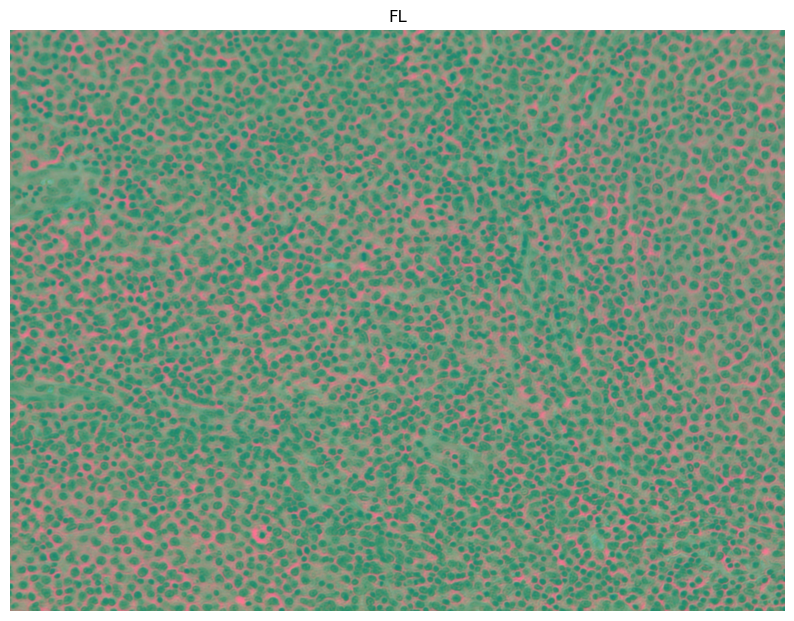

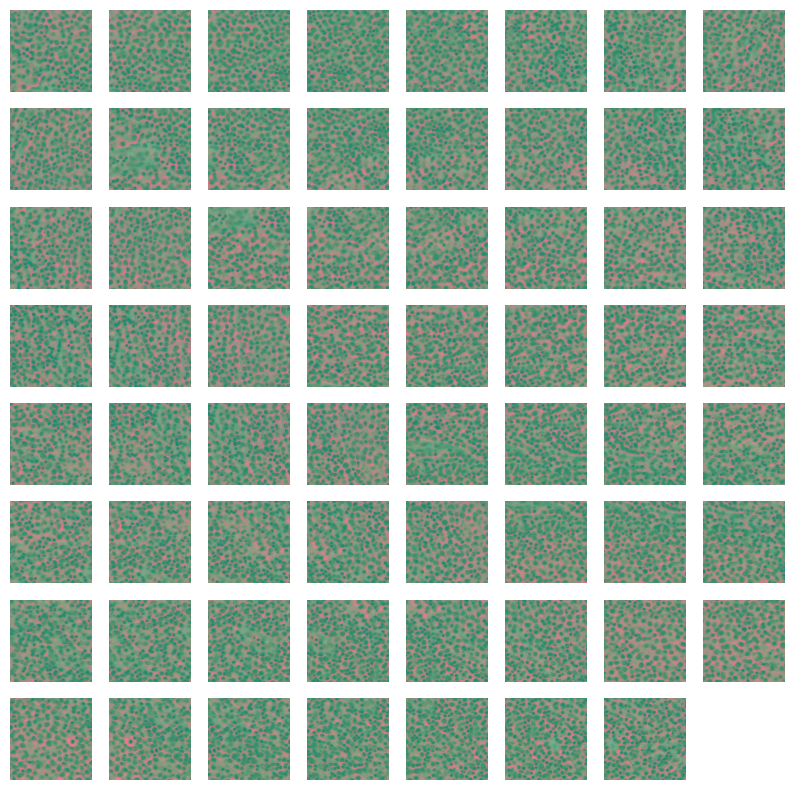

In [14]:
# read image
image = tf.keras.utils.load_img(file_path)  # load image in rgb format

# convert to numpy array
image = tf.keras.utils.img_to_array(image, dtype=np.float32)

# normalize image to [0, 1]
image = image / 255.0

# convert to desired color space
if COLOR_SPACE == 'lab':
    image = rgb2lab(image)
    # sRGB projected in Lab fit in an area of L=[0,100], a=[-87,99], b=[-108, 95]
    image[:, :, 0] /= 100
    image[:, :, 1] = (image[:, :, 1] + 87) / 186
    image[:, :, 2] = (image[:, :, 2] + 108) / 203

# plot image
plt.figure(figsize=(10, 10))
plt.imshow(image)
# set label as title
plot_label = 'CLL'
if label == 1:
    plot_label = 'FL'
elif label == 2:
    plot_label = 'MCL'

plt.title(plot_label)
plt.axis('off')
plt.show()

# extract patches
image = tf.expand_dims(image, axis=0)
patches = tf.image.extract_patches(images=image,
                                   sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
                                   strides=[1, PATCH_SIZE//2, PATCH_SIZE//2, 1],
                                   rates=[1, 1, 1, 1],
                                   padding='VALID')

# reshape to 4D tensor with shape (num_patches, patch_size, patch_size, channels)
patches = tf.reshape(patches, shape=[-1, [1, PATCH_SIZE, PATCH_SIZE, 1][1],
                                     [1, PATCH_SIZE, PATCH_SIZE, 1][2],
                                     tf.shape(image)[-1]])

# plot all patches
plt.figure(figsize=(10, 10))
for i in range(patches.shape[0]):
    plt.subplot(8, 8, i + 1)
    plt.imshow(patches[i])
    plt.axis('off')

plt.show()


## Load feature extractor and classifier

In [15]:

model = CNN(input_shape=(PATCH_SIZE, PATCH_SIZE, INPUT_CHANNELS), filters=(64,128,256,512), compression_depth=4)
weight_file = 'cnn_' + COLOR_SPACE + '/cnn' if not COLOR_SPACE == 'rgb' else 'cnn/cnn'
model.load_weights(weight_file)

output = model.layers[-2].output
feature_extractor = tf.keras.Model(inputs=model.input, outputs=output)

if CLASSIFIER_TYPE == 'svm':
    filename = 'cnn_' + COLOR_SPACE + '_svm.pkl'
    classifier = pickle.load(open(filename, 'rb'))
elif CLASSIFIER_TYPE == 'xgboost':
    filename = 'cnn_' + COLOR_SPACE + '_xgboost.pkl'
    classifier = pickle.load(open(filename, 'rb'))

## Get predictions

In [16]:

# extract features
features = feature_extractor.predict(patches, steps=len(patches))

# get predictions
predictions = classifier.predict_proba(features)
predictions = np.argmax(predictions, axis=1)
img_prediction = scipy.stats.mode(predictions)[0][0]
img_prediction = 'CLL' if img_prediction == 0 else 'FL' if img_prediction == 1 else 'MCL'


63/63 [==============================] - 0s 2ms/step


## Plot results

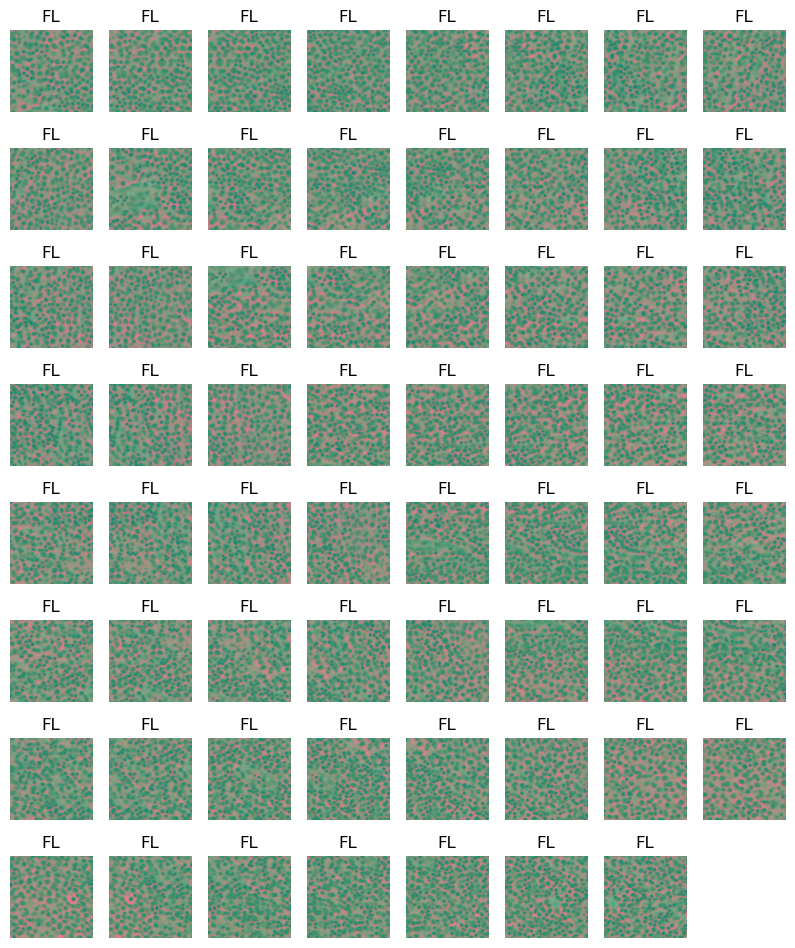

In [17]:
# plot patches with respective classification
plt.figure(figsize=(10, 12))
for i in range(patches.shape[0]):
    plt.subplot(8, 8, i + 1)
    plt.imshow(patches[i])
    plt.axis('off')
    plt.title('CLL' if predictions[i] == 0 else 'FL' if predictions[i] == 1 else 'MCL')

plt.show()

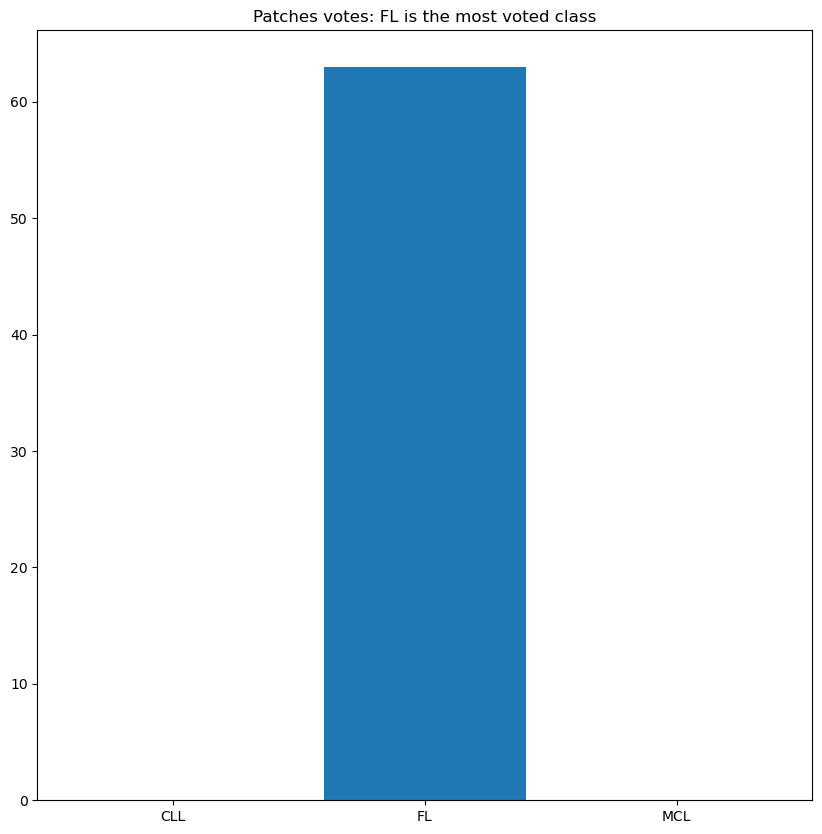

In [18]:
# plot bar plot of predictions
plt.figure(figsize=(10, 10))
votes = [np.sum(predictions == 0), np.sum(predictions == 1), np.sum(predictions == 2)]
plt.bar(['CLL', 'FL', 'MCL'], votes)
plt.title('Patches votes: ' + img_prediction + ' is the most voted class')
plt.show()